## Create a 30-spill sample .csv from 10,000 spill file
- Subsample 30 most eastern locations
- Plot spill locations on map

In [1]:
import cartopy.crs
from cartopy import feature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy
import xarray
import pandas
import pathlib
import yaml
from haversine import haversine

In [2]:
# map information
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)
fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")
# spill csv file location
spill_locations = pathlib.Path('/ocean/rmueller/MIDOSS/spill_files_bargefix_p1p2p3_v2/SalishSea_oil_spills_1.csv')
# load spill locations
spill_locs = pandas.read_csv(spill_locations)
spill_locs.head(1)

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template
0,2018-02-13 04:00,7,-125.229881,50.047127,166,408,ferry,84,316001243,NaN,NaN,62382.598348,0.0,40548.688926,fuel,Lagrangian_diesel.dat


In [3]:
# define axis limits
axlim = numpy.zeros(4)
axlim[0] = spill_locs.spill_lon.min()
axlim[1] = spill_locs.spill_lon.max()
axlim[2] = spill_locs.spill_lat.min()
axlim[3] = spill_locs.spill_lat.max()

### define sub-sample size

In [4]:
nrows = 30
spill_locs_30 = {}

lat = {}
lon = {}
# turn point
lat['tp'] = 48.68813
lon['tp'] = -123.23622
# BP
lat['bp'] = 48.86111
lon['bp'] = -122.758

### Sub-sample 30 spill locations based on Easternmost locations

In [5]:
# sort the spills by longitude
spill_locs = spill_locs.sort_values(
    by="spill_lon",
    ascending=False).reset_index(drop=True)
# extract the first nrows
spill_locs_30["easternmost"] = spill_locs.iloc[:nrows]

### Sub-sample 30 spill locations based on biggest spills

In [6]:
# sort the spills by longitude
spill_locs = spill_locs.sort_values(
    by="spill_volume",
    ascending=False).reset_index(drop=True)
# extract the first nrows
spill_locs_30["largest"] = spill_locs.iloc[:nrows]

### Sub-sample 30 nearest spills to Turn Point

In [8]:
tp = (lat['tp'],lon['tp'])
spill_locs['distance_tp'] = numpy.zeros(spill_locs['spill_lat'].shape[0])
for idx,spill_lats in enumerate(spill_locs['spill_lat']):
    spill_site = (spill_locs['spill_lat'][idx], spill_locs['spill_lon'][idx])
    spill_locs['distance_tp'][idx] = haversine(
        tp, 
        spill_site
    )
# sort the spills by longitude
spill_locs = spill_locs.sort_values(
    by="distance_tp",
    ascending=True).reset_index(drop=True)
# extract the 30 closest spills to TP
spill_locs_30["Turn Point"] = spill_locs.iloc[:nrows]

/tmp/ipykernel_31013/1084646080.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spill_locs['distance_tp'][idx] = haversine(


In [9]:
bp = (lat['bp'],lon['bp'])
spill_locs['distance_bp'] = numpy.zeros(spill_locs['spill_lat'].shape[0])
for idx,spill_lats in enumerate(spill_locs['spill_lat']):
    spill_site = (spill_locs['spill_lat'][idx], spill_locs['spill_lon'][idx])
    spill_locs['distance_bp'][idx] = haversine(
        bp, 
        spill_site
    )
# sort the spills by longitude
spill_locs = spill_locs.sort_values(
    by="distance_bp",
    ascending=True).reset_index(drop=True)
# extract the 30 closest spills to TP
spill_locs_30["BP terminal"] = spill_locs.iloc[:nrows]

/tmp/ipykernel_31013/942831338.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spill_locs['distance_bp'][idx] = haversine(


##### Weight spill volumes by max volume for plotting 

In [10]:
# spill_volume_fraction = {}
# max_spill_volume = max(spill_locs_30.spill_volume)
# min_spill_volume = min(spill_locs_30.spill_volume)
# spill_volume_fraction = spill_locs_30.spill_volume/max_spill_volume 

### Plot locations

In [11]:
grouping = [*spill_locs_30]
grouping

['easternmost', 'largest', 'Turn Point', 'BP terminal']

[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
easternmost
largest
Turn Point
BP terminal


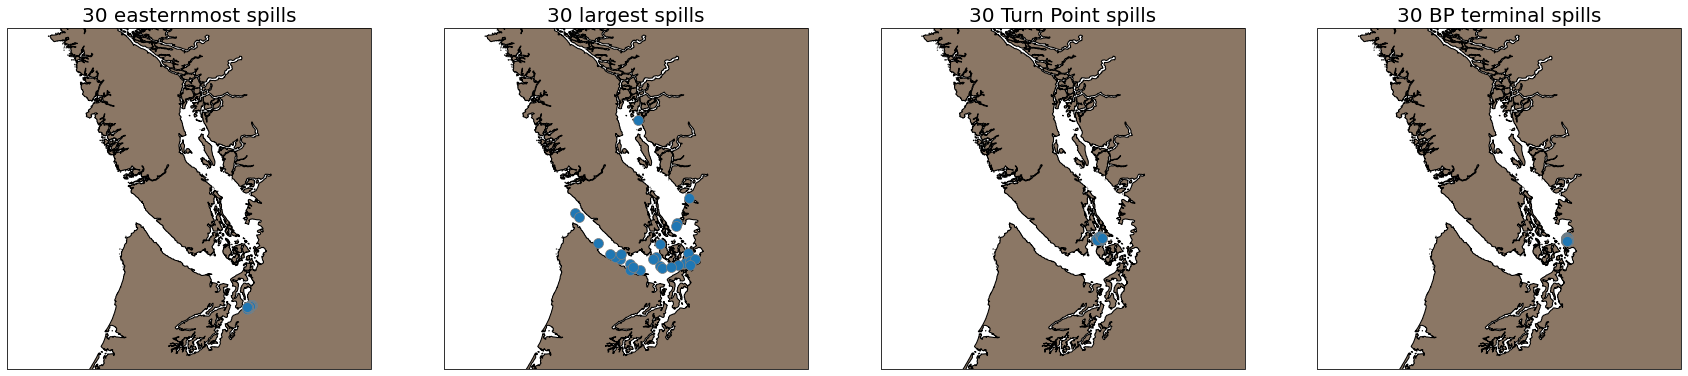

In [15]:
fs = 20
# ms = 300
# fs_legend = 12
# fs_legend_title = 16
import matplotlib.gridspec as gridspec

rotated_crs = cartopy.crs.RotatedPole(
    pole_longitude=120.0, 
    pole_latitude=63.75
)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

fig,axs = plt.subplots(
    1, len(grouping), figsize=(30, 15), 
    subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)
print(axs)
for idx,group_id in enumerate(grouping):
    print(group_id)
    terminal_loc = 0
    axs[idx].add_feature(feature.GSHHSFeature(
        'full', 
        edgecolor='k', 
        facecolor='#8b7765'
    ), zorder=1)
    scatter_bunker = axs[idx].scatter(
        spill_locs_30[group_id].spill_lon, 
        spill_locs_30[group_id].spill_lat, 
        s = 100, #ms * spill_volume_fraction,
        #label = spill_volume_fraction.values.tolist(),
        #color='yellow',
        #alpha = 0.5,
        edgecolors='grey',
        linewidth=0.7,
        transform=plain_crs,
        zorder=2)
    axs[idx].set_extent(axlim, crs=plain_crs)
    axs[idx].set_title(f'30 {group_id} spills', fontsize=fs)
plt.show()

In [16]:
spill_locs_30["Turn Point"]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_tp
0,2018-06-20 01:00,7,-123.234525,48.691818,256,542,cargo,264,563052700,NaN,NaN,3.959014e+06,0.0,3.563113e+05,fuel,Lagrangian_diesel.dat,0.428570
1,2018-04-29 03:00,7,-123.239863,48.684691,257,542,other,0,367346510,NaN,NaN,3.105295e+01,0.0,9.315886e-01,fuel,Lagrangian_bunker.dat,0.466627
2,2018-02-26 09:00,7,-123.227720,48.689143,256,543,cargo,347,566483000,NaN,NaN,4.245901e+06,0.0,4.245901e+04,fuel,Lagrangian_bunker.dat,0.634057
3,2018-10-09 04:00,7,-123.247426,48.680196,257,541,cargo,230,374696000,NaN,NaN,2.288376e+06,0.0,4.805590e+05,fuel,Lagrangian_bunker.dat,1.206273
4,2018-03-01 05:00,7,-123.248779,48.695221,256,541,cargo,304,477684200,NaN,NaN,6.660086e+06,0.0,1.998026e+05,fuel,Lagrangian_bunker.dat,1.213068
5,2018-06-19 14:00,7,-123.243462,48.678200,257,541,tanker,184,538006302,Canada,Canada,8.022709e+05,53000000.0,4.011355e+04,fuel,Lagrangian_bunker.dat,1.225510
6,2018-02-11 21:00,7,-123.252502,48.683509,257,541,cargo,185,319653000,NaN,NaN,9.381391e+05,0.0,9.381391e+03,fuel,Lagrangian_bunker.dat,1.301072
7,2018-07-08 23:00,7,-123.216682,48.694904,256,543,cargo,180,477588100,NaN,NaN,9.598879e+05,0.0,9.598879e+03,fuel,Lagrangian_bunker.dat,1.619880
8,2018-05-31 01:00,7,-123.229693,48.702213,256,543,cargo,199,353718000,NaN,NaN,2.425417e+06,0.0,2.425417e+04,fuel,Lagrangian_bunker.dat,1.637626
9,2018-04-12 03:00,7,-123.223996,48.700849,256,543,cargo,273,374923000,NaN,NaN,2.408693e+06,0.0,2.408693e+04,fuel,Lagrangian_bunker.dat,1.674842


In [19]:
spill_locs_30["BP terminal"]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_tp,distance_bp
0,2018-07-22 16:00,7,-122.757703,48.863930,245,574,barge,41,366887970,Phillips 66 Ferndale Refinery,BP Cherry Point Refinery,6.219816e+05,1.040000e+07,2.052539e+05,fuel,Lagrangian_diesel.dat,40.145438,0.314293
1,2018-11-08 10:00,7,-122.764648,48.861407,245,574,barge,40,366866930,US,BP Cherry Point Refinery,9.427746e+04,2.030000e+07,6.599422e+03,fuel,Lagrangian_diesel.dat,39.565080,0.487476
2,2018-06-11 09:00,7,-122.764142,48.858147,245,574,barge,47,366767140,NaN,NaN,2.240260e+05,4.500000e+06,6.944808e+04,fuel,Lagrangian_diesel.dat,39.423334,0.557217
3,2018-08-04 22:00,7,-122.749133,48.861880,245,575,barge,51,366767150,BP Cherry Point Refinery,BP Cherry Point Refinery,5.702067e+05,5.200000e+06,2.223806e+05,fuel,Lagrangian_diesel.dat,40.586770,0.654291
4,2018-07-06 00:00,7,-122.768122,48.860144,245,573,barge,40,366866930,Phillips 66 Ferndale Refinery,BP Cherry Point Refinery,2.579101e+05,1.450000e+07,3.045000e+06,cargo,Lagrangian_bunker.dat,39.274743,0.748241
5,2018-06-24 05:00,7,-122.769353,48.856256,245,573,barge,41,366887970,BP Cherry Point Refinery,BP Cherry Point Refinery,6.479313e+05,1.100000e+07,6.479313e+03,fuel,Lagrangian_bunker.dat,38.987986,0.990549
6,2018-03-23 15:00,7,-122.772102,48.862141,245,573,atb,204,338616000,NaN,NaN,1.706338e+05,2.743107e+07,6.857767e+06,cargo,Lagrangian_gas.dat,39.128973,1.037976
7,2018-08-14 10:00,7,-122.770874,48.866033,245,573,barge,40,366866930,US,BP Cherry Point Refinery,1.748661e+05,1.170000e+07,6.120313e+04,fuel,Lagrangian_diesel.dat,39.421476,1.089275
8,2018-06-07 00:00,7,-122.772827,48.854994,245,573,atb,178,368006870,BP Cherry Point Refinery,Canada,2.215839e+05,1.702614e+07,2.553921e+06,cargo,Lagrangian_jet.dat,38.697701,1.280258
9,2018-09-29 23:00,7,-122.756922,48.847005,246,574,atb,204,338616000,NaN,NaN,7.471649e+04,2.194485e+07,5.486213e+06,cargo,Lagrangian_jet.dat,39.319893,1.570364


In [20]:
spill_locs_30["largest"]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template
0,2018-02-16 06:00,7,-123.709526,48.256621,285,510,tanker,273,338371000,Shell Puget Sound Refinery,Pacific,3.313195e+06,1.854470e+08,1.168316e+08,cargo,Lagrangian_diesel.dat
1,2018-09-07 14:00,7,-123.737320,48.221879,288,508,tanker,277,232012789,Pacific,US,3.641359e+06,1.854470e+08,9.457797e+07,cargo,Lagrangian_akns.dat
2,2018-02-12 23:00,7,-122.666903,48.515937,268,580,tanker,251,368127000,US,Marathon Anacortes Refinery (formerly Tesoro),1.685975e+06,1.854470e+08,8.716009e+07,cargo,Lagrangian_jet.dat
3,2018-06-03 18:00,7,-123.672356,48.214931,288,513,tanker,287,303294000,Pacific,US,3.924046e+06,1.854470e+08,8.345115e+07,cargo,Lagrangian_gas.dat
4,2018-06-30 08:00,7,-123.393817,48.173080,291,532,tanker,287,367688000,BP Cherry Point Refinery,Pacific,1.964882e+06,1.854470e+08,7.603327e+07,cargo,Lagrangian_other.dat
5,2018-05-21 16:00,7,-123.215858,48.610664,262,543,tanker,228,636013350,Pacific,Canada,1.631286e+06,1.262110e+08,7.446449e+07,cargo,Lagrangian_akns.dat
6,2018-10-13 21:00,7,-122.706360,48.643096,260,577,tanker,287,367688000,BP Cherry Point Refinery,US,3.927823e+06,1.854470e+08,6.119751e+07,cargo,Lagrangian_jet.dat
7,2018-01-01 12:00,7,-123.002556,48.341651,280,558,tanker,228,220518000,US,Pacific,2.211460e+06,1.262110e+08,5.679495e+07,cargo,Lagrangian_gas.dat
8,2018-06-15 15:00,7,-123.476906,48.209789,289,526,tanker,273,367067110,Pacific,Shell Puget Sound Refinery,1.372730e+06,1.854470e+08,5.377963e+07,cargo,Lagrangian_akns.dat
9,2018-10-14 15:00,7,-124.163829,48.291313,283,480,tanker,183,369040000,US,Shell Puget Sound Refinery,1.684915e+06,5.300000e+07,5.035000e+07,cargo,Lagrangian_akns.dat
